# Klasifikasi Data

## Klasifikasi Data Menggunakan Naive Bayes

### Naive Bayes
Naive Bayes adalah algoritma klasifikasi berbasis probabilitas yang didasarkan pada Teorema Bayes. Algoritma ini sering digunakan untuk klasifikasi teks, deteksi spam, analisis sentimen, dan diagnosis penyakit karena sederhana tetapi sangat efektif.  

### 1. Teorema Bayes  
Teorema Bayes menghitung probabilitas suatu kelas berdasarkan bukti yang diberikan:  

$
P(C | X) = \frac{P(X | C) \cdot P(C)}{P(X)}
$

- $P(C | X)$ → Probabilitas suatu kelas $(C)$ diberikan fitur $(X)$
- $P(X | C)$ → Probabilitas mendapatkan fitur $(X)$ jika kelasnya adalah $(C)$  
- $P(C)$ → Probabilitas awal kelas $(C)$ (prior probability)  
- $P(X)$ → Probabilitas fitur $(X)$ di semua kelas (normalisasi)  

### 2. Jenis-Jenis Naive Bayes  
Ada beberapa jenis Naïve Bayes tergantung pada distribusi data:  

- Gaussian Naive Bayes - Cocok untuk data numerik yang mengikuti distribusi normal.  
- Multinomial Naive Bayes - Cocok untuk teks dan frekuensi kata.  
- Bernoulli Naive Bayes - Cocok untuk fitur biner.

### Penjelasan Mendalam tentang Gaussian Naive Bayes (GNB)  

#### 1. Apa Itu Gaussian Naive Bayes?  
Gaussian Naive Bayes adalah versi dari Naive Bayes yang digunakan ketika fitur-fitur dalam dataset bersifat kontinu dan diasumsikan mengikuti distribusi Normal (Gaussian).

#### 2. Rumus Gaussian Naive Bayes  
GNB masih menggunakan Teorema Bayes seperti Naive Bayes biasa:  

$
P(C | X) = \frac{P(X | C) \cdot P(C)}{P(X)}
$

Namun, karena fitur-fitur dalam dataset adalah numerik, kita tidak bisa hanya menghitung frekuensi seperti pada Naive Bayes biasa.  
Sebagai gantinya, kita menggunakan fungsi distribusi Gaussian (Normal) berikut untuk menghitung probabilitas suatu fitur $ X_i $ dalam kelas $ C $ :  

$
P(X_i | C) = \frac{1}{\sqrt{2\pi\sigma_C^2}} \exp\left(-\frac{(X_i - \mu_C)^2}{2\sigma_C^2}\right)
$

di mana:  
- $ \mu_C $ = rata-rata (mean) fitur $ X_i $ dalam kelas $ C $  
- $ \sigma_C^2 $ = varians fitur $ X_i $ dalam kelas $ C $  
- $ \exp $ = fungsi eksponensial  

#### Implementasi Klasifikasi Data dengan Gaussian Naive Bayes

In [23]:
%pip install pymysql
%pip install psycopg2

In [24]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split , KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.naive_bayes import GaussianNB

In [25]:
def get_pg_data():
    conn = psycopg2.connect(
        host="postgresqltest-projectadzin.i.aivencloud.com",
        user="avnadmin",
        password="AVNS_k58rpi0pi31N8ucX-vK",
        database="defaultdb",
        port=16209
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM sepal")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-386c0068-projectadzin.l.aivencloud.com",
        user="avnadmin",
        password="AVNS_-Zr6_we8osFXobQb3qi",
        database="iris",
        port=16209
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM petal")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id' dan 'Class'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merged[feature_columns].values

In [26]:
X = df_merged[feature_columns]
y = df_merged["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=90, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merged["outlier"] = outlier_labels

# Pisahkan data dengan outlier dan tanpa outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])

# Membagi data menjadi training (80%) dan testing (20%)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    df_cleaned[feature_columns],
    label_encoder.transform(df_cleaned["class"]),
    test_size=0.2,
    random_state=42
)

# Pipeline dengan StandardScaler dan KNN
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Latih model pada data dengan outlier
knn_pipeline.fit(X_train_all, y_train_all)
y_pred_all = knn_pipeline.predict(X_test_all)
accuracy_all = accuracy_score(y_test_all, y_pred_all)
print("Akurasi dengan outlier:", accuracy_all)
print(classification_report(y_test_all, y_pred_all, target_names=label_encoder.classes_))

# Latih model pada data tanpa outlier
knn_pipeline.fit(X_train_clean, y_train_clean)
y_pred_clean = knn_pipeline.predict(X_test_clean)
accuracy_clean = accuracy_score(y_test_clean, y_pred_clean)
print("Akurasi tanpa outlier:", accuracy_clean)
print(classification_report(y_test_clean, y_pred_clean, target_names=label_encoder.classes_))

Akurasi dengan outlier: 0.9666666666666667
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      1.00      0.95         9
 Iris-virginica       1.00      0.91      0.95        11

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30

Akurasi tanpa outlier: 1.0
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       1.00      1.00      1.00         7
 Iris-virginica       1.00      1.00      1.00         8

       accuracy                           1.00        27
      macro avg       1.00      1.00      1.00        27
   weighted avg       1.00      1.00      1.00        27



Number of mislabeled points with outliers out of a total 30 points : 19
Accuracy with outliers: 36.67%
Mislabeled points with outliers:
Index: 0, True Label: Iris-versicolor, Predicted: Iris-setosa
Index: 2, True Label: Iris-virginica, Predicted: Iris-setosa
Index: 3, True Label: Iris-versicolor, Predicted: Iris-setosa
Index: 4, True Label: Iris-versicolor, Predicted: Iris-setosa
Index: 6, True Label: Iris-versicolor, Predicted: Iris-setosa
Index: 7, True Label: Iris-virginica, Predicted: Iris-setosa
Index: 8, True Label: Iris-versicolor, Predicted: Iris-setosa
Index: 9, True Label: Iris-versicolor, Predicted: Iris-setosa
Index: 10, True Label: Iris-virginica, Predicted: Iris-setosa
Index: 15, True Label: Iris-versicolor, Predicted: Iris-setosa
Index: 16, True Label: Iris-virginica, Predicted: Iris-setosa
Index: 17, True Label: Iris-versicolor, Predicted: Iris-setosa
Index: 18, True Label: Iris-versicolor, Predicted: Iris-setosa
Index: 19, True Label: Iris-virginica, Predicted: Iris-se

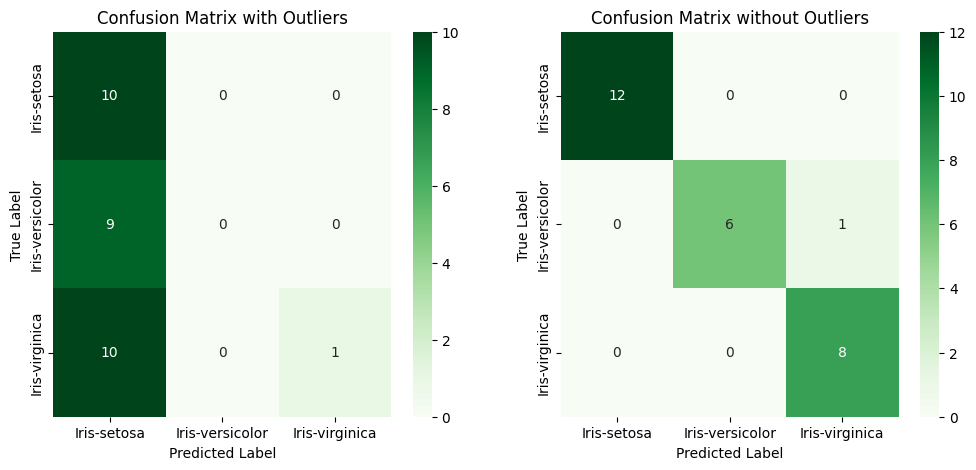

In [27]:
# Encode label kelas ke numerik
label_encoder = LabelEncoder()
df_merged["class_encoded"] = label_encoder.fit_transform(df_merged["class"])

# Data dengan outlier
X_all = df_merged[feature_columns]
y_all = df_merged["class_encoded"].values  # Pastikan dalam bentuk array numpy

# Data tanpa outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])
X_clean = df_cleaned[feature_columns]
y_clean = df_cleaned["class_encoded"].values  # Pastikan dalam bentuk array numpy

# Split data dengan outlier
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42)

# Split data tanpa outlier
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42)

# Inisialisasi model Naive Bayes
gnb = GaussianNB()

# Latih dan uji model dengan outlier
y_pred_all = gnb.fit(X_train_all, y_train_all).predict(X_test_all)
mislabeled_all = (y_test_all != y_pred_all).sum()
accuracy_all = accuracy_score(y_test_all, y_pred_all)
print("Number of mislabeled points with outliers out of a total %d points : %d" % (X_test_all.shape[0], mislabeled_all))
print("Accuracy with outliers: %.2f%%" % (accuracy_all * 100))

# Menampilkan label yang salah pada data dengan outlier
mislabeled_indices_all = np.where(y_test_all != y_pred_all)[0]
print("Mislabeled points with outliers:")
for i in mislabeled_indices_all:
    true_label = label_encoder.inverse_transform([int(y_test_all[i])])[0]
    predicted_label = label_encoder.inverse_transform([int(y_pred_all[i])])[0]
    print(f"Index: {i}, True Label: {true_label}, Predicted: {predicted_label}")
print()
# Latih dan uji model tanpa outlier
y_pred_clean = gnb.fit(X_train_clean, y_train_clean).predict(X_test_clean)
mislabeled_clean = (y_test_clean != y_pred_clean).sum()
accuracy_clean = accuracy_score(y_test_clean, y_pred_clean)
print("Number of mislabeled points without outliers out of a total %d points : %d" % (X_test_clean.shape[0], mislabeled_clean))
print("Accuracy without outliers: %.2f%%" % (accuracy_clean * 100))

# Menampilkan label yang salah pada data tanpa outlier
mislabeled_indices_clean = np.where(y_test_clean != y_pred_clean)[0]
print("Mislabeled points without outliers:")
for i in mislabeled_indices_clean:
    true_label = label_encoder.inverse_transform([int(y_test_clean[i])])[0]
    predicted_label = label_encoder.inverse_transform([int(y_pred_clean[i])])[0]
    print(f"Index: {i}, True Label: {true_label}, Predicted: {predicted_label}")

# Visualisasi Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test_all, y_pred_all), annot=True, fmt="d", cmap="Greens", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title("Confusion Matrix with Outliers")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(confusion_matrix(y_test_clean, y_pred_clean), annot=True, fmt="d", cmap="Greens", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title("Confusion Matrix without Outliers")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.show()